In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import skew, kurtosis
import functions
from functions import analisar_produtos as an
import importlib

importlib.reload(functions)


<module 'functions' from 'c:\\Users\\brunoo\\OneDrive\\Documentos\\Projeto_01\\functions.py'>

In [2]:
plt.style.use('ggplot')

# Etapa 0 - Coleta de Dados e Verificação da Integridade dos Dados

In [3]:
dataset = pd.read_csv("SuperMarketAnalysis.csv") 
dataset.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
print(dataset['Invoice ID'].nunique() == dataset.shape[0]) # Não há dados duplicados. 
print('\n') 
print(dataset.isnull().sum()) # Parece não existir valores Nulos

True


Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Sales                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64


In [5]:
#Vamos investigar a integridade dos dados quantitativos por meio do método describe(), o objetivo é observar
# se há valores inconcistentes como vendas (Sales) iguais ou menos que zero. 
dataset.describe()

,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


"Parece não existir nenhuma inconsistência nos dados quantitativos. A única variável que chama atenção é a de rating, por indicar ser um valor contínuo. Na prática, um sistema de classificação de satisfação do cliente geralmente é discreto. Isso é um pouco estranho, e a única explicação plausível, embora não muito provável, seria a possibilidade de ser um sistema ponderado."

In [6]:
# Agora, vamos avaliar a integridade dos dados qualitativos utilizando o método value_counts(). O objetivo é identificar inconsistências, 
# como por exemplo, na variável Gender em que pode ocorrer de valores como "Female" ou "F" e "Male" ou "M" estarem presentes no dataset. 
# Além disso, erros como a presença de valores "Not Available" são comuns em datasets, assim como outros tipos de inconsistências 
# geradas por consultas SQL mal estruturadas.

print(dataset['Branch'].value_counts())
print('\n') 
print(dataset['City'].value_counts())
print('\n') 
print(dataset['Customer type'].value_counts())




Branch
Alex     340
Cairo    332
Giza     328
Name: count, dtype: int64


City
Yangon       340
Mandalay     332
Naypyitaw    328
Name: count, dtype: int64


Customer type
Member    565
Normal    435
Name: count, dtype: int64


In [7]:
print(dataset['Gender'].value_counts())
print('\n')
print(dataset['Product line'].value_counts())
print('\n')
print(dataset['Payment'].value_counts())


Gender
Female    571
Male      429
Name: count, dtype: int64


Product line
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: count, dtype: int64


Payment
Ewallet        345
Cash           344
Credit card    311
Name: count, dtype: int64


In [8]:
dataset['Date'] = pd.to_datetime(dataset['Date']) 
dataset['Date']


0     2019-01-05
1     2019-03-08
2     2019-03-03
3     2019-01-27
4     2019-02-08
         ...    
995   2019-01-29
996   2019-03-02
997   2019-02-09
998   2019-02-22
999   2019-02-18
Name: Date, Length: 1000, dtype: datetime64[ns]

# Etapa 01 - Análise Descritiva de Dados 

## Vendas, Lucros e outras características. 


In [9]:
# parece que as duas colunas possuem o mesmo valor, o que não repesenta o que foi dito no dicionário de dados do dataset.
# Sendo assim, vamos tratar o gross income como margem bruta estimada.
(dataset['gross income'] - dataset['Tax 5%']).sum()

np.float64(0.0)

In [10]:
# Resumo Estatístico dos Dados Quantitativos por Filial 
summary = (
    dataset.groupby('Branch')[['Sales', 'Unit price', 'cogs', 'gross income']]
    .agg([
        ('mean', 'mean'),
        ('std', 'std'),
        ('min', 'min'),
        ('q1', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q3', lambda x: x.quantile(0.75)),
        ('max', 'max'),
        ('skew', lambda x: x.skew()),
        ('kurtosis', lambda x: x.kurt())
    ])
)
 


In [11]:
summary['Sales']

,mean,std,min,q1,median,q3,max,skew,kurtosis
Branch,,,,,,,,,
Alex,312.354031,231.640025,12.6945,137.489625,240.82800,459.340875,1039.29,0.905500,-0.003526
Cairo,319.872506,242.447565,18.6375,119.936250,252.88200,465.585750,1022.49,0.888505,-0.158076
Giza,337.099715,263.160870,10.6785,121.474500,271.41975,495.754875,1042.65,0.855874,-0.177354


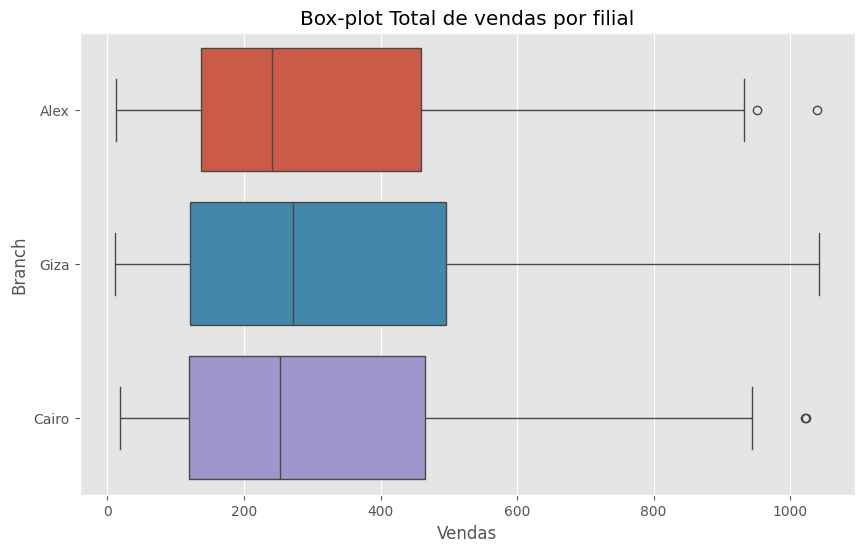

In [12]:
#box -plot das Vendas

plt.figure(figsize=(10,6))

sns.boxplot(data= dataset, x='Sales', y='Branch', hue='Branch')
plt.title("Box-plot Total de vendas por filial")
plt.xlabel("Vendas")
plt.show()

A exibição de mútilos box-plot no mesmo gráfico é especialmente valiosa, quando comparamos dados por categorias. Observe que, embora a filial de Giza apresente a maior mediana, podemos dizer com base no tamnho das caixas no box-plot que não há uma grande variabilidade nas vendas entre as diferentes filiais. Note que há alguns outliars na filial de Cairo e de Alex

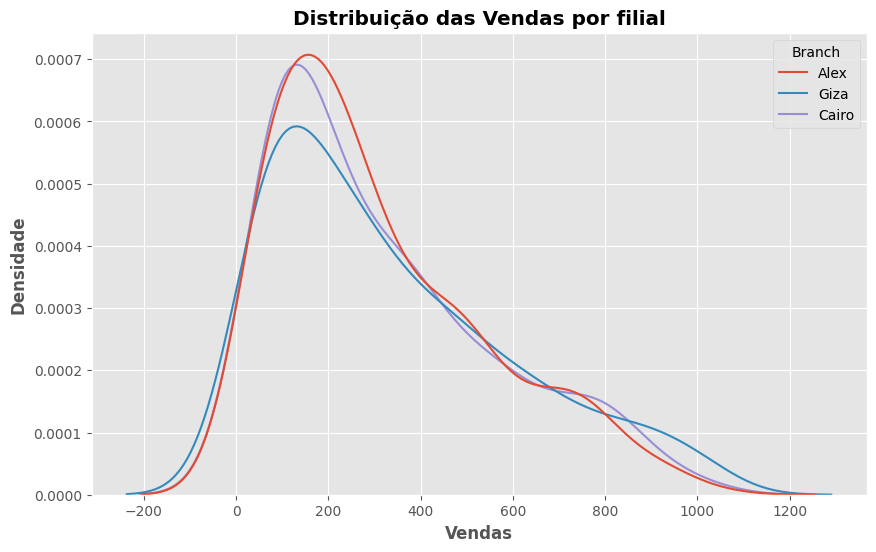

In [13]:
plt.figure(figsize=(10,6))

sns.kdeplot(data=dataset, x='Sales', hue='Branch')
plt.title('Distribuição das Vendas por filial', weight= 'bold') 
plt.xlabel('Vendas',weight= 'bold')
plt.ylabel('Densidade', weight= 'bold')
plt.show()


In [14]:
# Lucro bruto 
summary['gross income']

,mean,std,min,q1,median,q3,max,skew,kurtosis
Branch,,,,,,,,,
Alex,14.874001,11.030477,0.6045,6.547125,11.46800,21.873375,49.49,0.905500,-0.003526
Cairo,15.232024,11.545122,0.8875,5.711250,12.04200,22.170750,48.69,0.888505,-0.158076
Giza,16.052367,12.531470,0.5085,5.784500,12.92475,23.607375,49.65,0.855874,-0.177354


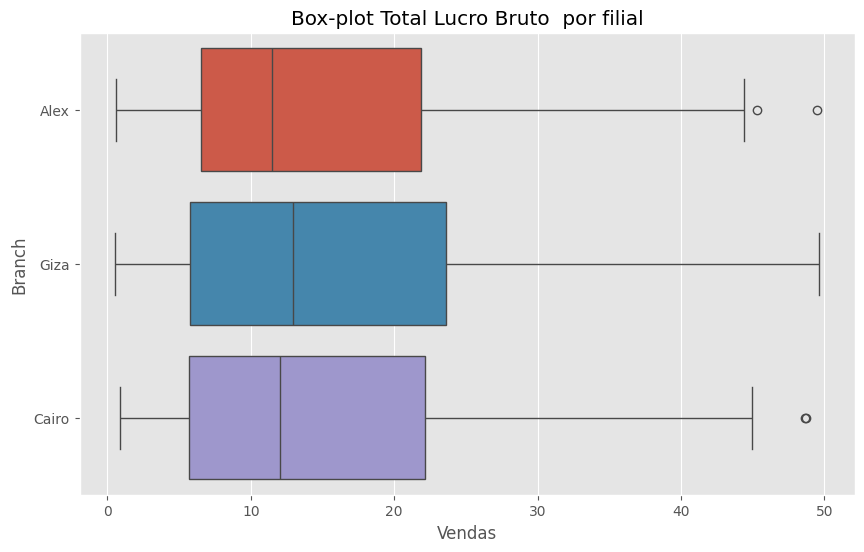

In [15]:
# box-plot
plt.figure(figsize=(10,6))

sns.boxplot(data= dataset, x='gross income', y='Branch', hue='Branch')
plt.title("Box-plot Total Lucro Bruto  por filial")
plt.xlabel("Vendas")
plt.show()

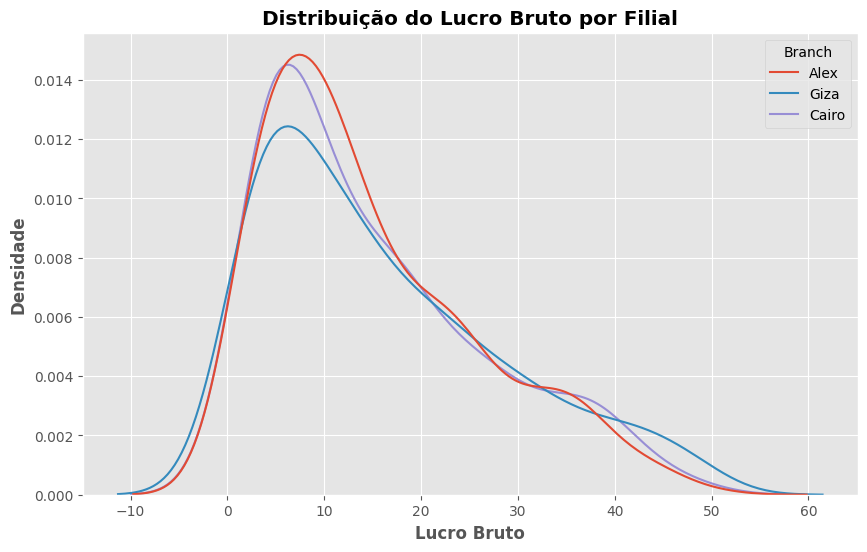

In [16]:
plt.figure(figsize=(10,6))

sns.kdeplot(data=dataset, x='gross income', hue='Branch')
plt.title('Distribuição do Lucro Bruto por Filial', weight= 'bold') 
plt.xlabel('Lucro Bruto',weight= 'bold')
plt.ylabel('Densidade', weight= 'bold')
plt.show()

In [17]:
dataset['Product line'].value_counts()

Product line
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: count, dtype: int64

In [18]:
summary_product = (
    dataset.groupby(['Branch','Product line'])[['Sales', 'Unit price', 'cogs', 'gross income']]
    .agg([
        ('mean', 'mean'),
        ('std', 'std'),
        ('min', 'min'),
        ('q1', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q3', lambda x: x.quantile(0.75)),
        ('max', 'max'),
        ('skew', lambda x: x.skew()),
        ('kurtosis', lambda x: x.kurt())
    ])
)

In [ ]:

summary_product_sales = summary_product['Sales']
summary_product_sales['mean']

mean         std      min          q1  \
Branch Product line                                                          
Alex   Electronic accessories  305.285225  246.411455  30.4080  101.490375   
       Fashion accessories     320.245265  257.255822  12.6945   94.179750   
       Food and beverages      295.915526  205.761806  33.4320  165.193875   
       Health and beauty       268.037298  186.079373  19.2465  135.549750   
       Home and lifestyle      344.879931  246.511642  19.1940  147.672000   
       Sports and travel       328.350839  235.076176  16.1070  148.527750   
Cairo  Electronic accessories  310.026245  250.401657  26.7225  112.024500   
       Fashion accessories     264.730911  203.755302  35.1960  111.389250   
       Food and beverages      304.297770  220.888774  56.4060  151.641000   
       Health and beauty       376.993585  259.566580  18.6375  145.971000   
       Home and lifestyle      350.983290  267.137830  33.9360  120.652875   
       Sports and travel       322.390306  246.927203  34.6290  100.414125   
Giza   Electronic accessories  344.890445  243.505198  31.7520  136.342500   
       Fashion accessories     331.693385  265.166027  13.1670  125.055000   
       Food and beverages      360.103864  293.862985  22.6590   94.626000   
       Health and beauty       319.525500  247.608362  32.2770  106.871625   
       Home and lifestyle      308.790067  255.445086  14.6790  122.524500   
       Sports and travel       350.265067  271.062493  10.6785  132.562500   

                                 median          q3        max      skew  \
Branch Product line                                                        
Alex   Electronic accessories  207.0705  442.622250   931.0350  0.931649   
       Fashion accessories     277.6725  485.173500  1039.2900  0.764347   
       Food and beverages      249.0705  356.346375   932.3370  1.272595   
       Health and beauty       217.1820  370.980750   752.6400  0.959075   
       Home and lifestyle      263.1300  493.794000   951.8250  0.722460   
       Sports and travel       271.2780  465.990000   926.9505  0.846356   
Cairo  Electronic accessories  225.0150  446.911500   942.4485  0.970151   
       Fashion accessories     185.7555  380.354625   874.1250  1.156488   
       Food and beverages      234.8010  434.988750   888.6150  1.041767   
       Health and beauty       350.0700  565.215000   922.6350  0.454568   
       Home and lifestyle      262.5840  507.176250  1022.4900  0.966572   
       Sports and travel       275.3100  467.586000   944.6220  0.763114   
Giza   Electronic accessories  272.5800  486.979500   864.5700  0.597486   
       Fashion accessories     267.3405  472.311000  1042.6500  0.963063   
       Food and beverages      292.5405  553.392000  1034.4600  0.771506   
       Health and beauty       275.6040  473.248125   950.2500  0.866047   
       Home and lifestyle      206.7975  441.693000  1023.7500  1.213547   
       Sports and travel       266.0280  517.965000  1002.1200  0.799788   

                               kurtosis  
Branch Product line                      
Alex   Electronic accessories -0.305583  
       Fashion accessories    -0.181808  
       Food and beverages      1.385670  
       Health and beauty       0.336907  
       Home and lifestyle     -0.490832  
       Sports and travel      -0.015158  
Cairo  Electronic accessories -0.107516  
       Fashion accessories     0.695796  
       Food and beverages      0.319004  
       Health and beauty      -0.790105  
       Home and lifestyle     -0.008772  
       Sports and travel      -0.482010  
Giza   Electronic accessories -0.813673  
       Fashion accessories     0.283504  
       Food and beverages     -0.600750  
       Health and beauty      -0.153341  
       Home and lifestyle      0.997403  
       Sports and travel      -0.171545

In [20]:
summary_product_sales = summary_product['Sales']

In [21]:
resultados = an(summary_product_sales)

print("* Produtos com Vendas Mais Estáveis:")
print(resultados["Mais Estáveis"])





* Produtos com Vendas Mais Estáveis:
   Branch            Product line        cv
9   Cairo       Health and beauty  0.688517
3    Alex       Health and beauty  0.694229
2    Alex      Food and beverages  0.695340
12   Giza  Electronic accessories  0.706036
4    Alex      Home and lifestyle  0.714775


todas as categorias apresentam variabilidade alta nas vendas :  CV > 0.68

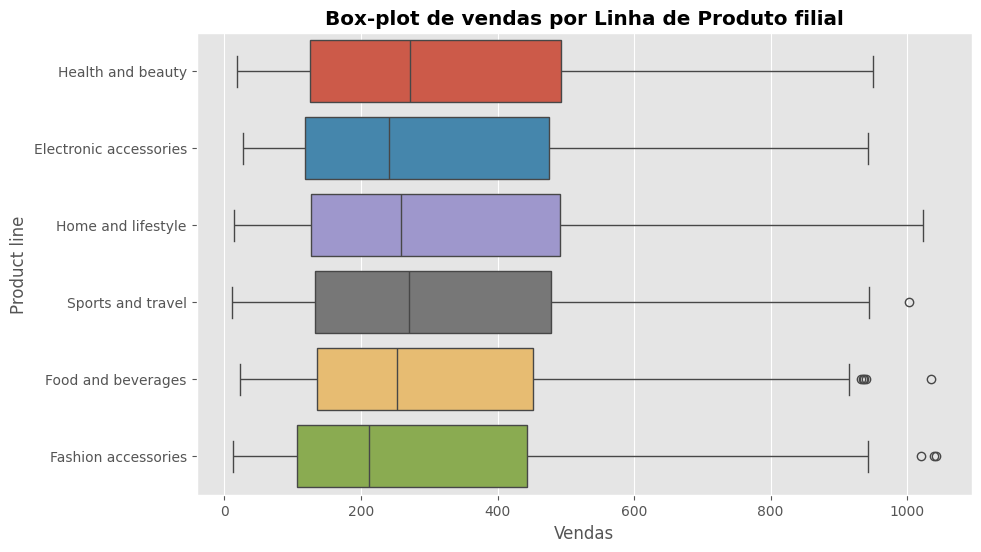

In [34]:
# box-plot
plt.figure(figsize=(10,6))

sns.boxplot(data=dataset, x='Sales', y='Product line',hue='Product line')
plt.title("Box-plot de vendas por Linha de Produto filial" ,weight='bold')
plt.xlabel("Vendas")
plt.show()

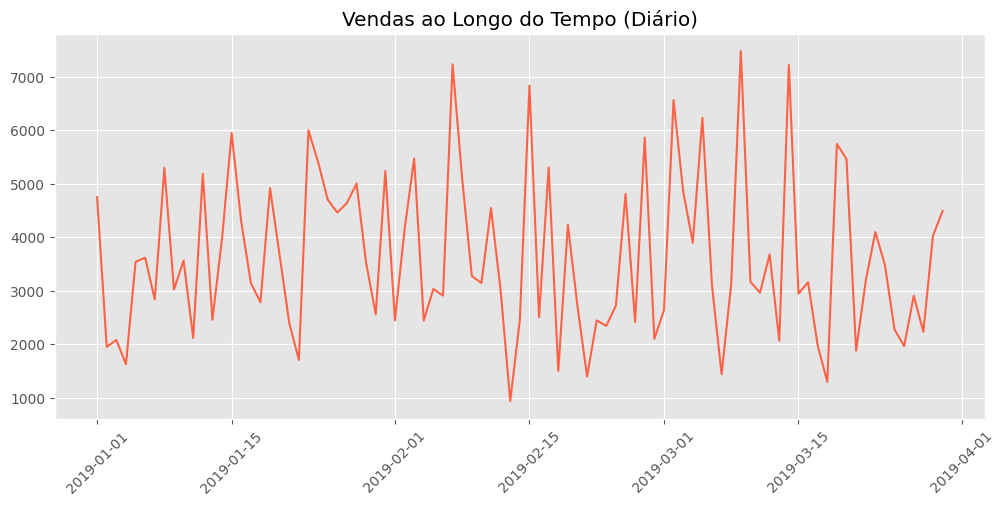

In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

df_daily = dataset.groupby('Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_daily['Date'], df_daily['Sales'], color='tomato')
plt.title('Vendas ao Longo do Tempo (Diário)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



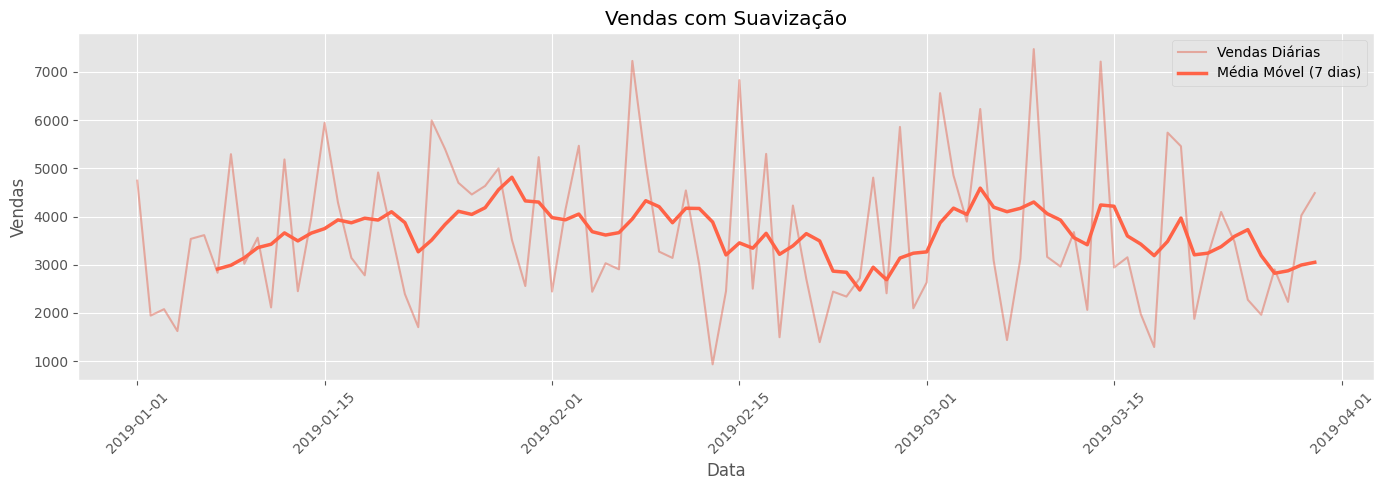

In [23]:
df_daily['Sales_MA7'] = df_daily['Sales'].rolling(window=7).mean()

plt.figure(figsize=(14,5))
plt.plot(df_daily['Date'], df_daily['Sales'], alpha=0.4, label='Vendas Diárias')
plt.plot(df_daily['Date'], df_daily['Sales_MA7'], color='tomato', linewidth=2.5, label='Média Móvel (7 dias)')
plt.title('Vendas com Suavização')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


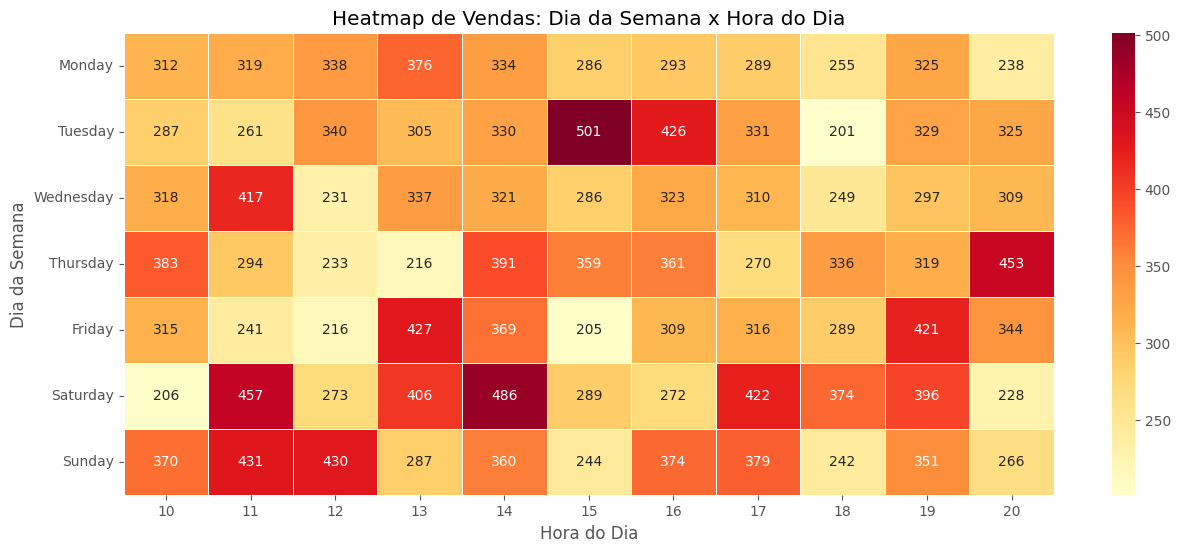

In [24]:
dataset['Time'] = pd.to_datetime(dataset['Time'], format='%I:%M:%S %p')

dataset['Hour'] = dataset['Time'].dt.hour
dataset['Weekday'] = dataset['Date'].dt.day_name()  # ou .dt.weekday para números

# Cria a tabela de vendas por dia da semana e hora
pivot = dataset.pivot_table(index='Weekday', columns='Hour', values='Sales', aggfunc='mean')

# Reordena os dias
dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(dias_ordem)

# Plot do heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.5, annot=True, fmt='.0f')
plt.title('Heatmap de Vendas: Dia da Semana x Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Dia da Semana')
plt.show()